In [44]:
# Quantum Machine Learning
import pennylane as qml
from pennylane import qaoa

from qiskit.algorithms import QAOA

# Classical Machine Learning
import tensorflow as tf

# Generation of graphs
import networkx as nx

# Standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import random

# Fix the seed for reproducibility, which affects all random functions in this demo
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

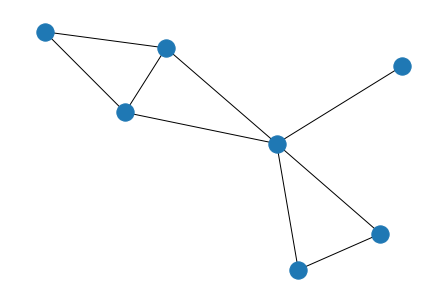

In [72]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx."""

    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints

# Define parameters of the graphs
n_graphs = 20
n_nodes = 7
p_edge = 3.0 / n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(graphs[0])

In [73]:
def qaoa_from_graph(graph, n_layers=1):
    """Uses QAOA to create a cost Hamiltonian for the MaxCut problem."""

    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))

    # Define the structure of the cost and mixer subcircuits for the MaxCut problem
    cost_h, mixer_h = qaoa.maxcut(graph)

    # Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)

    # Creates the actual quantum circuit for the QAOA algorithm
    def circuit(params, **kwargs):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, n_layers, params[0], params[1])
        return qml.expval(cost_h)

    # Evaluates the cost Hamiltonian
    def hamiltonian(params, **kwargs):
        """Evaluate the cost Hamiltonian, given the angles and the graph."""

        # We set the default.qubit.tf device for seamless integration with TensorFlow
        dev = qml.device("default.qubit.tf", wires=len(graph.nodes))

        # This qnode evaluates the expectation value of the cost hamiltonian operator
        cost = qml.QNode(circuit, dev, interface="tf", diff_method="backprop")

        return cost(params)

    return hamiltonian

# Create an instance of a QAOA circuit given a graph.
cost = qaoa_from_graph(graph=graphs[0], n_layers=1)

# Since we use only one layer in QAOA, params have the shape 1 x 2,
# in the form [[alpha, gamma]].
x = tf.Variable([[0.5], [0.5]], dtype=tf.float32)

# Evaluate th QAOA instance just created with some angles.
print(cost(x))



"""

qaoa = QAOA(optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))

result = qaoa.compute_minimum_eigenvalue(qubit_op)
"""


tf.Tensor(-2.434257557347492, shape=(), dtype=float64)


"\n\nqaoa = QAOA(optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))\n\nresult = qaoa.compute_minimum_eigenvalue(qubit_op)\n"

In [94]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
"""
# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw()

qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()
"""
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

# Create an instance of a QAOA circuit given a graph.
#cost = qaoa_from_graph(graph=graphs[0], n_layers=1)



# Since we use only one layer in QAOA, params have the shape 1 x 2,
# in the form [[alpha, gamma]].
x = tf.Variable([[0.5], [0.5]], dtype=tf.float32)
#x=[0.5, 0.5]
#create_qaoa_circ(graphs[0],x)
G=graphs[0]
func=get_expectation(G, 1)
# Evaluate th QAOA instance just created with some angles.
print(func(x))

TypeError: object of type 'ResourceVariable' has no len()

In [75]:
# Set the number of layers in the QAOA ansatz.
# The higher the better in terms of performance, but it also gets more
# computationally expensive. For simplicity, we stick to the single layer case.
n_layers = 1

# Define a single LSTM cell.
# The cell has two units per layer since each layer in the QAOA ansatz
# makes use of two parameters.
cell = tf.keras.layers.LSTMCell(2 * n_layers)

# We create the QAOA MaxCut cost functions of some graphs
#graph_cost_list = [qaoa_from_graph(g) for g in graphs]
graph_cost_list = [get_expectation(g,1) for g in graphs]



In [92]:
def rnn_iteration(inputs, graph_cost, n_layers=1):
    """Perform a single time step in the computational graph of the custom RNN."""

    # Unpack the input list containing the previous cost, parameters,
    # and hidden states (denoted as 'h' and 'c').
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]
    #print(prev_cost, prev_params,prev_h,prev_c)
    #above matches
    # Concatenate the previous parameters and previous cost to create new input
    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])
    #print(new_input)
    #above matches
    
    # Call the LSTM cell, which outputs new values for the parameters along
    # with new internal states h and c
    new_params, [new_h, new_c] = cell(new_input, states=[prev_h, prev_c])
    #print(new_params)
    #POSS ERROR, this is differnt than original we keep getting 00 no mater what
    #NEVERMIND other gets 00 sometimes too
    
    # Reshape the parameters to correctly match those expected by PennyLane
    _params = tf.reshape(new_params, shape=(2, n_layers))
    #print(_params)
    # Evaluate the cost using new angles
    
    #_params=_params.numpy().tolist()
    #_params=np.reshape(_params,(2))
    np_pars=_params.numpy().tolist()
    np_pars=np.reshape(np_pars,(2))
    #_params=np.reshape(_params,(2,n_layers))
    
    
    #print(_params)
    np_cost = graph_cost(np_pars)
    _cost=tf.convert_to_tensor(np_cost)#tf.Tensor(_cost)
    print(_cost)
    
    # Reshape to be consistent with other tensors
    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape=(1, 1))
    print('it return')
    print([new_cost, new_params, new_h, new_c])
    #THIS FUNC looks fine
    return [new_cost, new_params, new_h, new_c]


def recurrent_loop(graph_cost, n_layers=1, intermediate_steps=False):
    """Creates the recurrent loop for the Recurrent Neural Network."""

    # Initialize starting all inputs (cost, parameters, hidden states) as zeros.
    initial_cost = tf.zeros(shape=(1, 1))
    initial_params = tf.zeros(shape=(1, 2 * n_layers))
    initial_h = tf.zeros(shape=(1, 2 * n_layers))
    initial_c = tf.zeros(shape=(1, 2 * n_layers))

    # We perform five consecutive calls to 'rnn_iteration', thus creating the
    # recurrent loop. More iterations lead to better results, at the cost of
    # more computationally intensive simulations.
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)

    # This cost function takes into account the cost from all iterations,
    # but using different weights.
    loss = tf.keras.layers.average(
        [0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]]
    )
    print('newthing')
    print([out0[1], out1[1], out2[1], out3[1], out4[1], loss])
    print('newthingend')
    print(loss)
    #not the current issue
    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1], loss]
        

    else:
    
        return loss
    
def train_step(graph_cost):
    """Single optimization step in the training procedure."""

    with tf.GradientTape() as tape:
        print(tape)
        # Evaluates the cost function
        loss = recurrent_loop(graph_cost)
    print('loss')
    print(loss)
    print(cell.trainable_weights)
    print('done')
    # Evaluates gradients, cell is the LSTM cell defined previously
    grads = tape.gradient(loss, cell.trainable_weights)
    #the inputs to grads are fine
    # Apply gradients and update the weights of the LSTM cell
    print(grads)
    opt.apply_gradients(zip(grads, cell.trainable_weights))
    return loss

In [93]:
# Select an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        print(i)
        print(graph_cost)
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(graph_cost_list)} - Loss: {loss[0][0]}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

Epoch 1
0
<function get_expectation.<locals>.execute_circ at 0x0000026C54947678>
tf.Tensor(-4.5498047, shape=(), dtype=float32)
it return
[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-4.5498047]], dtype=float32)>, <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>, <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>, <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>]
tf.Tensor(-4.6621094, shape=(), dtype=float32)
it return
[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-4.6621094]], dtype=float32)>, <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.03902049, -0.18979521]], dtype=float32)>, <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.03902049, -0.18979521]], dtype=float32)>, <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.449665 , -0.2545796]], dtype=float32)>]
tf.Tensor(-4.7841797, shape=(), dtype=float32)
it return
[<tf.Tensor: shape=(1, 1), dty

ValueError: No gradients provided for any variable: ['lstm_cell_4/kernel:0', 'lstm_cell_4/recurrent_kernel:0', 'lstm_cell_4/bias:0'].

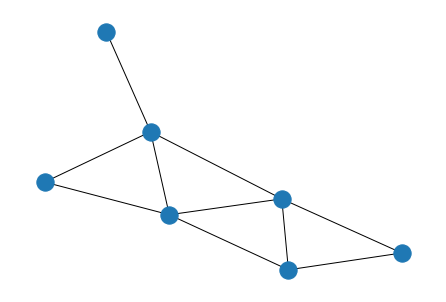

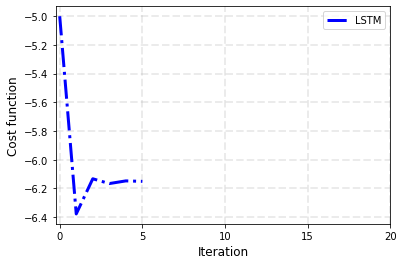

In [14]:
new_graph = nx.gnp_random_graph(7, p=3 / 7)
#new_cost = qaoa_from_graph(new_graph)
new_cost = get_expectation(new_graph,1)

nx.draw(new_graph)

# Apply the RNN (be sure that training was performed)
res = recurrent_loop(new_cost, intermediate_steps=True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape=(2 * n_layers, 1))
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
final_loss = res[5]

# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape=(2, n_layers))) for guess in guesses]

fig, ax = plt.subplots()

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.legend()
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()



Step 1 - Loss = -4.778125020606964
Step 2 - Loss = -5.021846710386333
Step 3 - Loss = -5.245049256345186
Step 4 - Loss = -5.444397183723359
Step 5 - Loss = -5.6177365085201005
Step 6 - Loss = -5.7643375879592975
Step 7 - Loss = -5.8851872093396445
Step 8 - Loss = -5.982827442720083
Step 9 - Loss = -6.060735253157997
Step 10 - Loss = -6.122592228411034
Step 11 - Loss = -6.171754459950065
Step 12 - Loss = -6.211009806300491
Step 13 - Loss = -6.242551089315066
Step 14 - Loss = -6.268057165753381
Step 15 - Loss = -6.2888034259865915
Final cost function: -6.30576281305346
Optimized angles: [[-0.40587313]
 [ 0.34315004]]


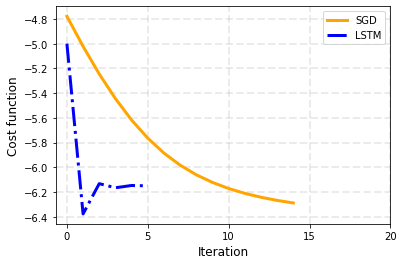

In [15]:
# Parameters are randomly initialized
x = tf.Variable(np.random.rand(2, 1))

# We set the optimizer to be a Stochastic Gradient Descent
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
step = 15

# Training process
steps = []
sdg_losses = []
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x)

    steps.append(x)
    sdg_losses.append(loss)

    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_+1} - Loss = {loss}")

print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

fig, ax = plt.subplots()

plt.plot(sdg_losses, color="orange", lw=3, label="SGD")

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.legend()
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()